# AGN selections

Plots and stats for AGN section of the paper.

In [162]:
import pandas as pd
import numpy as np
import pickle as pcl

from scipy.stats import binned_statistic

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from astropy.cosmology import Planck13, z_at_value
import astropy.units as u

from methods import normalise_coods
from methods import z_distort
from methods import factor_h
from methods import bhattacharyya

from overdensity_cylinder import overdensity_cylinder

h = 0.673
L = 480.279 / h

c = 2.97e8 # m s^-1

# directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
directory = '/cosma/home/dp004/dc-love2/gpfs/protoclusters_data/'

Load data

In [5]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')

In [6]:
for i, z in enumerate(zees):
    for gals in [gals_sfr, gals_mstar]:
        gals[i] = z_distort(factor_h(gals[i], h), z, L)

#         print "Filling in NaN values..."
        gals[i].ix[np.isnan(gals[i]['z0_haloId']), 'z0_haloId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_centralId']), 'z0_centralId'] = -1
        gals[i].ix[np.isnan(gals[i]['z0_central_mcrit200']), 'z0_central_mcrit200'] = 0
    

Quasar / HzRG accretion limits

In [7]:
def luminosity_to_accretion(lum, epsilon=0.1):    
    acc = lum / epsilon / c**2
    acc /= 1.989e30
    acc *= (365.25*24*60*60)
    acc /= 1e7
    return acc

quasar_lim = luminosity_to_accretion(1e44, epsilon)
cons_quasar_lim = luminosity_to_accretion(1e45, epsilon)

radio_lim = 0.001
cons_radio_lim = 0.005

print "quasar limits:", quasar_lim, cons_quasar_lim
print "radio limits:", radio_lim, cons_radio_lim

quasar limits: 0.0179868985573 0.179868985573
radio limits: 0.001 0.005


## Number densities

Hopkins+06 fits

In [480]:
def H06(x, z=0,hubble_units=0,**kwargs):
    """
    Inputs: xmin, xmax - range along x-axis
            z - redshift
            *args - optional plotting arguments
    """

    h100=0.7
    phi_star=10.**(-4.825) #/h100**3
    zref=2.
    log10L_star0=13.036  # L_star is in Lsun
    kL1=0.632
    kL2=-11.76
    kL3=-14.25
    gamma10=0.417
    kg1=-0.623
    gamma20=2.174
    kg21=1.460
    kg22=-0.793
    
    eps=np.log10((1+z)/(1+zref))
    x_star=log10L_star0+kL1*eps+kL2*eps**2+kL3*eps**3
    if hubble_units==2: x_star=x_star+2*np.log10(h100)
    xx=10.**(x-x_star)
    gamma1=gamma10*10.**(eps*kg1)
    gamma2=2.*gamma20/(10.**(eps*kg21)+10.**(eps*kg22))
    y=phi_star/(xx**gamma1+xx**gamma2)
    if hubble_units==1 or hubble_units==2: y=y/h100**3
    return y


In [455]:
def accr_to_lbol(accr, sol=True, epsilon=0.1):
    lbol = accr / (365.25*24*60*60) * c**2 * epsilon * 1.989e30 * 1e7
    if sol: lbol /= 3.9e33
    return lbol

In [456]:
BinLimits = np.linspace(7, 15, 41)
Bins = np.linspace(7.1, 14.9, 40)

print BinLimits
print Bins

[  7.    7.2   7.4   7.6   7.8   8.    8.2   8.4   8.6   8.8   9.    9.2
   9.4   9.6   9.8  10.   10.2  10.4  10.6  10.8  11.   11.2  11.4  11.6
  11.8  12.   12.2  12.4  12.6  12.8  13.   13.2  13.4  13.6  13.8  14.
  14.2  14.4  14.6  14.8  15. ]
[  7.1   7.3   7.5   7.7   7.9   8.1   8.3   8.5   8.7   8.9   9.1   9.3
   9.5   9.7   9.9  10.1  10.3  10.5  10.7  10.9  11.1  11.3  11.5  11.7
  11.9  12.1  12.3  12.5  12.7  12.9  13.1  13.3  13.5  13.7  13.9  14.1
  14.3  14.5  14.7  14.9]


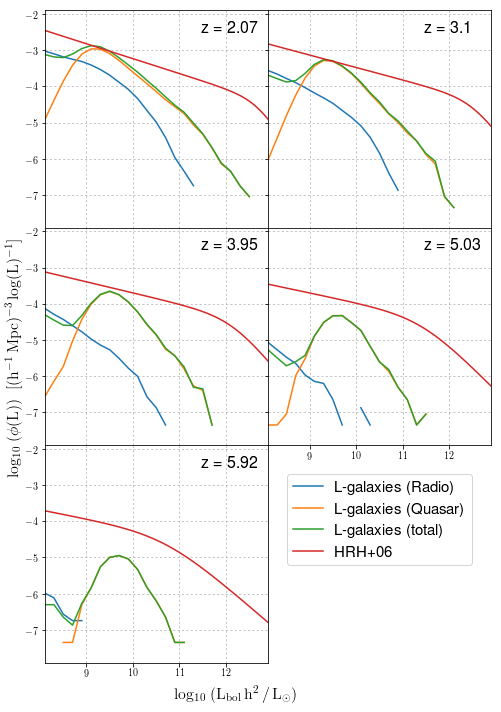

In [550]:
fig = plt.figure(figsize=(8,12))#, dpi=200)

gs = gridspec.GridSpec(3,2)

gs.update(hspace=0, wspace=0) # bottom = 0.57, top = 1,

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])

axes = [ax1,ax2,ax3,ax4,ax5]

for i, ax in zip(range(5), axes):
    
    total_accr =  gals[i]['zn_radioAccretionRate'] + gals[i]['zn_quasarAccretionRate']
    total_accr = total_accr[total_accr > 0.]
    
    radio_accr =  gals[i]['zn_radioAccretionRate']
    radio_accr = radio_accr[radio_accr > 0.]
    
    quasar_accr =  gals[i]['zn_quasarAccretionRate']
    quasar_accr = quasar_accr[quasar_accr > 0.]
    
    Lbol = accr_to_lbol(radio_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (Radio)')
    
    Lbol = accr_to_lbol(quasar_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (Quasar)')
    
    Lbol = accr_to_lbol(total_accr)
    phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
    phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
    ax.plot(Bins, np.log10(phi), label='L-galaxies (total)')

    x = np.linspace(6,13.5,num=101)
    H06_fit = H06(x, z=zees[i], hubble_units=2)
    ax.plot(x, np.log10(H06_fit), label='HRH+06')
    # plot_H06(6, 15, z=zees[i])

    ax.text(0.7, 0.9, 'z = %s'%zees[i], transform=ax.transAxes, size=16)

    ax.set_xlim(8.1, 12.9)
    ax.set_ylim(-7.9, -1.9)

    ax.grid(alpha=0.9, linestyle='dotted')


ax5.legend(bbox_to_anchor=(1.95, 0.9), prop={'size': 15})

for ax in [ax2, ax4]:
    ax.set_yticklabels([])
    
    
fig.text(0.35, 0.08, '$\mathrm{log_{10} \; (L_{bol} \, h^{2} \,/\, L_{\odot})}$', 
         size=16, transform=fig.transFigure)

fig.text(0.06, 0.6, '$\mathrm{log_{10} \; (\phi(L)) \;\; [(h^{-1} \, Mpc)^{-3} \, log(L)^{-1}] }$', 
         size=16, transform=fig.transFigure, rotation=90)

# fig.savefig('../images/Lgals_agn_LF.png', dpi=300)

integrate LF to give number densities

In [574]:
from scipy.integrate import quad
from scipy.integrate import trapz

i = 0

quad(H06, 11.0, np.inf, zees[i])[0]

9.177986020554424e-05

In [578]:
total_accr =  gals[i]['zn_radioAccretionRate'] # + gals[i]['zn_quasarAccretionRate']
Lbol = accr_to_lbol(total_accr[total_accr > 0.])

phi, bins = np.histogram(np.log10(Lbol * h**2), bins=BinLimits)
phi = phi / (L*h)**3 / (BinLimits[1] - BinLimits[0])
trapz(phi[Bins > 9.5], Bins[Bins > 9.5])

4.6048670705512847e-05

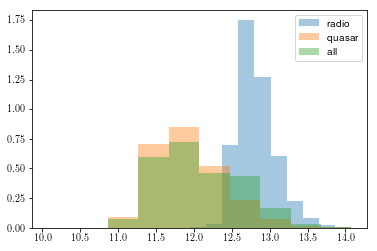

In [586]:
total_accr =  gals[i]['zn_radioAccretionRate'] #+ gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='radio');

total_accr = gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='quasar');

total_accr =  gals[i]['zn_radioAccretionRate'] + gals[i]['zn_quasarAccretionRate']
Lbol = np.log10(accr_to_lbol(total_accr))

plt.hist(np.log10(gals[i]['zn_mvir'][Lbol > 9.5] * 1e10), alpha=0.4, normed=True, label='all');

plt.legend()

## Black hole masses

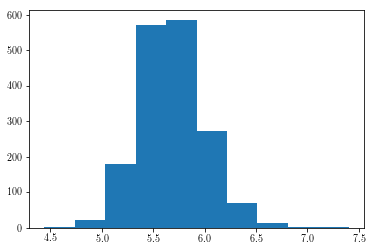

In [464]:
plt.hist(np.log10(gals[4]['zn_blackHoleMass'][gals[4]['zn_blackHoleMass'] > 0.] * 1e10));

## Average host halo mass

In [277]:
from matplotlib.colors import LogNorm

q_accr_lim = 0.
r_accr_lim = 1e-4

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)

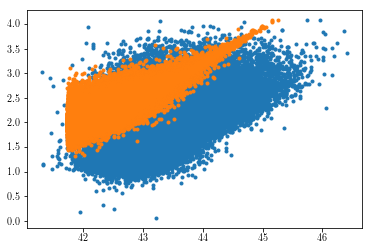

In [278]:
plt.plot(np.log10(accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim], sol=False)),
         np.log10(gals[i]['zn_mvir'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim]), '.');


plt.plot(np.log10(accr_to_lbol(gals[i]['zn_radioAccretionRate'][gals[i]['zn_radioAccretionRate'] > r_accr_lim], sol=False)),
         np.log10(gals[i]['zn_mvir'][gals[i]['zn_radioAccretionRate'] > r_accr_lim]), '.');

(42, 48)

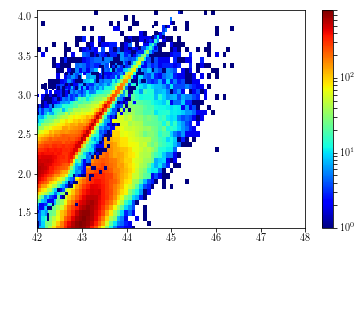

In [283]:
plt.hist2d(np.log10(accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim], sol=False)),
         np.log10(gals[i]['zn_mvir'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim]), 
           bins=60, cmap=my_cmap, vmin=1,  norm=LogNorm());

plt.hist2d(np.log10(accr_to_lbol(gals[i]['zn_radioAccretionRate'][gals[i]['zn_radioAccretionRate'] > r_accr_lim], sol=False)),
         np.log10(gals[i]['zn_mvir'][gals[i]['zn_radioAccretionRate'] > r_accr_lim]), 
           bins=60, cmap=my_cmap, vmin=1,  norm=LogNorm());

plt.colorbar();

plt.xlim(42, 48)

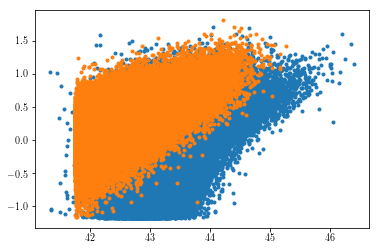

In [275]:
plt.plot(np.log10(accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim], sol=False)),
         np.log10(gals[i]['zn_stellarMass'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim]), '.')

plt.plot(np.log10(accr_to_lbol(gals[i]['zn_radioAccretionRate'][gals[i]['zn_radioAccretionRate'] > r_accr_lim], sol=False)),
         np.log10(gals[i]['zn_stellarMass'][gals[i]['zn_radioAccretionRate'] > r_accr_lim]), '.')

(42, 48)

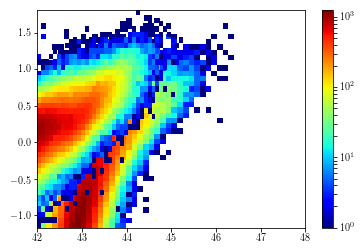

In [284]:
plt.hist2d(np.log10(accr_to_lbol(gals[i]['zn_quasarAccretionRate'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim], sol=False)),
         np.log10(gals[i]['zn_stellarMass'][gals[i]['zn_quasarAccretionRate'] > q_accr_lim]), 
           bins=40, cmap=my_cmap, vmin=1, norm=LogNorm());

plt.hist2d(np.log10(accr_to_lbol(gals[i]['zn_radioAccretionRate'][gals[i]['zn_radioAccretionRate'] > r_accr_lim], sol=False)),
         np.log10(gals[i]['zn_stellarMass'][gals[i]['zn_radioAccretionRate'] > r_accr_lim]), 
           bins=40, cmap=my_cmap, vmin=1, norm=LogNorm());

plt.colorbar();

plt.xlim(42, 48)

## Accretion rate distributions

(1e-08, 0.01)

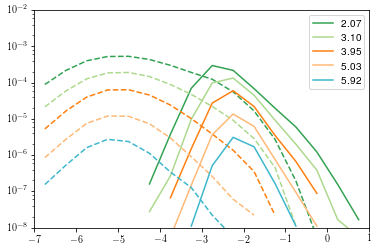

In [472]:
massBinLimits = np.linspace(-7, 1, 17)
massBins = np.linspace(-6.75, 0.75, 16)

for i in range(5):
    
    ### Quasar ###
    quasar_accr = gals[i]['zn_quasarAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    quasar_accr = quasar_accr[quasar_accr > 0.]
    
    phi, bins = np.histogram(np.log10(quasar_accr), bins=massBinLimits)
    phi = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, phi, label=redshiftz[i], c=cmap[i])

    ### Radio ###
    radio_accr = gals[i]['zn_radioAccretionRate'] #/ (365.25*24*60*60) * c**2 * epsilon * 1e7
    radio_accr = radio_accr[radio_accr > 0.]
    
    phi, bins = np.histogram(np.log10(radio_accr), bins=massBinLimits)
    phi = phi / L**3 / (massBinLimits[1] - massBinLimits[0])
    plt.semilogy(massBins, phi, c=cmap[i], linestyle='dashed')#label=redshiftz[i],
    
    
plt.legend()
plt.xlim(massBinLimits[0],massBinLimits[-1])

plt.vlines(13, 1e-8, 1e-2, linestyle='dashed', color='grey', alpha=0.5)
plt.ylim(1e-8,1e-2)

### Quasar / HzRG distance from protocluster centre

In [8]:
gals = gals_sfr

for i, redshift in enumerate(redshifts[:5]):
    
    agn = gals[i][gals[i]['zn_radioAccretionRate'] >= radio_lim].reset_index(drop=True) # find all agn    
    agn = agn[agn['z0_central_mcrit200'] >= 1.48e4].reset_index(drop=True)  # agn in protoclusters
    
    distances = [None] * len(agn)

    for idx, q in agn.iterrows():
        
        # subset coordinates of descendant halo
        subset_gals = gals[i][gals[i]['z0_centralId'] == q['z0_centralId']]
        
        coods = normalise_coods(np.array(subset_gals[['zn_x','zn_y','zn_z']]), L)  # normalise coordinates
        center = np.median(coods,axis=0) # find descendant halo center
        quasar_location = coods[subset_gals['zn_galaxyId'] == q['zn_galaxyId']]
        
        # distance between agn and descendant halo progenitor centre
        distances[idx] = float(np.sqrt(np.sum((quasar_location - center)**2, axis=1)))  
    
    
    print "z:", redshift, "n(quasar):", len(agn), "\nmean:", round(np.mean(distances),2),\
    "median:", round(np.median(distances),2), "std:", round(np.std(distances),2),"\n"
    

 z: 2p07 n(quasar): 8646 
mean: 4.84 median: 4.32 std: 2.86 

z: 3p10 n(quasar): 2706 
mean: 4.92 median: 4.3 std: 3.14 

z: 3p95 n(quasar): 561 
mean: 4.7 median: 3.97 std: 3.02 

z: 5p03 n(quasar): 46 
mean: 4.92 median: 3.8 std: 3.51 

z: 5p92 n(quasar): 5 
mean: 6.01 median: 5.44 std: 3.26 



#### Find average galaxy distance from protocluster centre

In [ ]:
gals = gals_sfr

distances = [None] * len(redshifts)
centres = [None] * len(redshifts)

for i, redshift in enumerate(redshifts):
    
    clusters = pd.unique(gals[i][gals[i]['z0_central_mcrit200'] > 1.48e4]['z0_centralId'])
    
    distances[i] = [None] * len(clusters)
    centres[i] = [None] * len(clusters)

    for idx, c in enumerate(clusters):

        subset_gals = gals[i][gals[i]['z0_centralId'] == q['z0_centralId']]  # subset coordinates of descendant halo
        coods = norm_coods(np.array(subset_gals[['zn_x','zn_y','zn_z']]), L)  # normalise coordinates
        center = np.median(coods,axis=0) # find descendant halo center
        
        centres[i][idx] = center
        distances[i][idx] = np.mean(np.sqrt(np.sum(pow(coods - center, 2.),axis=1)))


In [110]:
print centres_sfr[0][858]
print centres_sm[0][858]

[ -6.4425    37.62117   60.228027]
[ 474.093445    37.616228    59.7259385]


In [89]:
np.array([np.mean(d) for d in distances_sfr]) - np.array([np.mean(d) for d in distances])

array([ 0.17565368,  0.22326523,  0.32186496,  0.57394775,  1.16955296])

In [91]:
[np.mean(d) for d in distances]

[3.1805097815790466,
 3.638861706029783,
 3.7562005969792125,
 3.6596361549541809,
 3.127022526595276]

In [92]:
[np.mean(d) for d in distances_sfr]

[3.3561634645848688,
 3.8621269365137061,
 4.0780655571072018,
 4.2335839075303445,
 4.2965754889552787]

!!!!

Need to calculate overdensity surrounding quasars in the model...

In [12]:
R = [3, 6, 10, 14, 20]

quasar_stats = {z: {'cstats': {r: None for r in R}, 'clusters': None} for z in zees[:5]}
hzrg_stats = {z: {'cstats': {r: None for r in R}, 'clusters': None} for z in zees[:5]}

In [13]:
# for i, z in enumerate(zees[:5]):
    
#     print z
    
#     # find all agn
#     hzrgs = gals[i][gals[i]['zn_radioAccretionRate'] >= radio_lim].reset_index(drop=True) 
#     quasars = gals[i][gals[i]['zn_quasarAccretionRate'] >= quasar_lim].reset_index(drop=True) 
    
#     # save cluster mass data
#     hzrg_stats[z]['clusters'] = hzrgs['z0_central_mcrit200']
#     quasar_stats[z]['clusters'] = quasars['z0_central_mcrit200']
    
#     for r in R:  # loop through aperture sizes
#         print r
    
#         quasar_stats[z]['cstats'][r] = overdensity_cylinder(gals_mstar[i], quasars[['zn_x','zn_y','zn_z']],
#                                                             L=L, R=r, dc=r)
        
#         hzrg_stats[z]['cstats'][r] = overdensity_cylinder(gals_mstar[i], hzrgs[['zn_x','zn_y','zn_z']],
#                                                           L=L, R=r, dc=r)

    
# pcl.dump([quasar_stats, hzrg_stats], open('agn_stats.p', 'w'))
quasar_stats, hzrg_stats = pcl.load(open('agn_stats.p', 'r'))

Quasar overdensity / descendant mass plot, figure 9

In [14]:
BinLimits = [np.linspace(-1, 39, 21), 
             np.linspace(-1, 17, 37),
             np.linspace(-1, 11, 25)]

Bins = [np.linspace(0, 38, 20),
        np.linspace(-0.75, 16.75, 36), 
        np.linspace(-0.75, 10.75, 24)]

print BinLimits[1]
print Bins[1]

[ -1.   -0.5   0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5
   5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5
  11.   11.5  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5
  17. ]
[ -0.75  -0.25   0.25   0.75   1.25   1.75   2.25   2.75   3.25   3.75
   4.25   4.75   5.25   5.75   6.25   6.75   7.25   7.75   8.25   8.75
   9.25   9.75  10.25  10.75  11.25  11.75  12.25  12.75  13.25  13.75
  14.25  14.75  15.25  15.75  16.25  16.75]


In [22]:
def func(x, a, b, c, d, C):
    return a * (x[1]+1)**b * (x[0]+1)**c + C


def scale(x):
    return np.log10(x * 1e3 * 1e10)


args=[1.45145241, -1.104172, 2.64782728, 1., 18.53122657]

scale(func(np.vstack([Bins[0], [2.07] * len(Bins[0])]), args[0], args[1], args[2], args[3],args[4]))

0 2.07
1 3.1
2 3.95
3 5.03


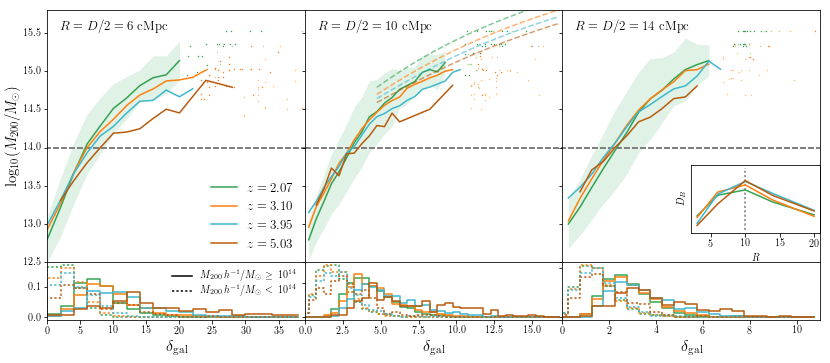

In [38]:
fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])
ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])
ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(zees[:4]))]

radii = [6,10,14]

for i, z in enumerate(zees[:4]):
    print i, z
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits, Bins):
        
        cluster_mask = quasar_stats[z]['clusters'] >= 1.48e4
        nan_mask = ~np.isinf(1 / quasar_stats[z]['clusters'])
        
        # Subplot
        phiB, mass = np.histogram(quasar_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(quasar_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                          np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                                 np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                                 bins=binLimits, statistic='count')[0]

        std = binned_statistic(quasar_stats[z]['cstats'][R][nan_mask,0] + 1, 
                               np.log10(quasar_stats[z]['clusters'][nan_mask] * 1e10),
                               bins=binLimits, statistic='std')[0]

        cmask = (count > 10)
        
        if i==0:
            axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], alpha=0.15, linewidth=0, color=cmap[i*2])

        axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %.2f$'%z)
        
        dgal_mask = quasar_stats[z]['cstats'][R][:,0] > max(bins[cmask])
        
        axt.scatter(quasar_stats[z]['cstats'][R][nan_mask & dgal_mask,0] + 1,
            np.log10(quasar_stats[z]['clusters'][nan_mask & dgal_mask] * 1e10),
            marker='.', s=8, c=cmap[i], lw=0, label=None)

        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        axt.hlines(14, -10, 60, linestyle='--', color='grey')
        
        axt.set_xticklabels([])
        
        # plot fitted mass
        if R == 10:
            axt.plot(bins[bins>4.5], scale(func(np.vstack([bins[bins>4.5], [z] * len(bins[bins>4.5])]), 
                     args[0],args[1],args[2],args[3],args[4])), color=cmap[i*2], 
                     linestyle='dashed', alpha=0.6)

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        if(i==0):
            axt.text(0.05, 0.92, '$R = D/2 = %s \; \mathrm{cMpc}$'%R, transform=axt.transAxes, size=13)


# Calculate R = 20 & 3 Bhattacharya distance, but don't plot
for i, z in enumerate(zees[:4]):
    
    for R, switch, binLimits, bins in zip([3,20],[True,False], BinLimits, Bins):
        
        cluster_mask = quasar_stats[z]['clusters'] >= 1.48e4
        
        # Subplot
        phiB, mass = np.histogram(quasar_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(quasar_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(zees[:4]):
    ax9.plot([3] + radii + [20], Bhatta[i], color=cmap[i*2])
    
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
ax9.set_yticks([])

# ax9.set_xticklabels([4,6,8,10,12,14,16,18,''])
ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(10, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.5,15.8)
    

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} \, h^{-1} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} \, h^{-1} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False, prop={'size':13})

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

    
for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta_{\mathrm{gal}}$', size=16, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('output/quasar_select.png', bbox_inches='tight', dpi=300)

HzRG overdensity / descendant mass plot, figure 10

In [40]:
BinLimits = [np.linspace(-1, 38, 14), 
             np.linspace(-1, 17, 19),
             np.linspace(-1, 11, 13)]

Bins = [np.linspace(0.5, 36.5, 13),
        np.linspace(-0.5, 16.5, 18), 
        np.linspace(-0.5, 10.5, 12)]

print BinLimits[2]
print Bins[2]

[ -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.]
[ -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5]


0 2.07
1 3.1
2 3.95
3 5.03


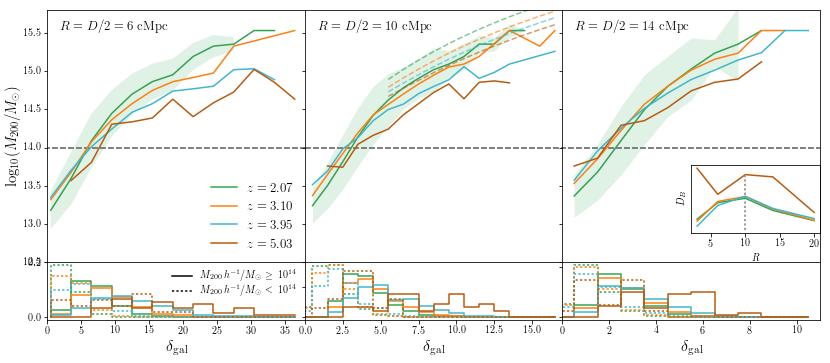

In [43]:
fig = plt.figure(figsize=(15,10))

gs1 = gridspec.GridSpec(32, 26)

gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0:26,0:8])
ax5 = fig.add_subplot(gs1[26:32,0:8])
ax2 = fig.add_subplot(gs1[0:26,8:16])
ax6 = fig.add_subplot(gs1[26:32,8:16])
ax3 = fig.add_subplot(gs1[0:26,16:24])
ax7 = fig.add_subplot(gs1[26:32,16:24])
ax9 = fig.add_subplot(gs1[16:23,20:24])

Bhatta =[[] for i in range(len(zees[:4]))]

radii = [6,10,14]

for i, z in enumerate(zees[:4]):
    print i, z
    
    for axt, axb, R, binLimits, bins in zip([ax1,ax2,ax3], [ax5,ax6,ax7], radii, BinLimits, Bins):
        
        cluster_mask = hzrg_stats[z]['clusters'] >= 1.48e4
        nan_mask = ~np.isinf(1 / hzrg_stats[z]['clusters'])
        
        # Subplot
        phiB, mass = np.histogram(hzrg_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(hzrg_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        Bhatta[i].append(DB)

        # Main Plot
        median = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                          np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                          bins=binLimits, statistic='median')[0]

        count = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                                 np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                                 bins=binLimits, statistic='count')[0]

        std = binned_statistic(hzrg_stats[z]['cstats'][R][nan_mask,0] + 1, 
                               np.log10(hzrg_stats[z]['clusters'][nan_mask] * 1e10),
                               bins=binLimits, statistic='std')[0]

        cmask = (count > 0)
        
        if np.sum(cmask) == 0:
            print 'not enough radio galaxies...'
        else:
        
            if i==0:
                axt.fill_between(bins[cmask], median[cmask]+std[cmask], median[cmask]-std[cmask], 
                                 alpha=0.15, linewidth=0, color=cmap[i*2])

            axt.plot(bins[cmask], median[cmask], color=cmap[i*2], label='$z = %.2f$'%z)

            dgal_mask = hzrg_stats[z]['cstats'][R][:,0] > max(bins[cmask])

            axt.scatter(hzrg_stats[z]['cstats'][R][nan_mask & dgal_mask,0] + 1,
                np.log10(hzrg_stats[z]['clusters'][nan_mask & dgal_mask] * 1e10),
                marker='.', s=8, c=cmap[i], lw=0, label=None)

            
        # plot fitted mass
        if R == 10:
            axt.plot(bins[bins>4.5], scale(func(np.vstack([bins[bins>4.5], [z] * len(bins[bins>4.5])]), 
                     args[0],args[1],args[2],args[3],args[4])), color=cmap[i*2], 
                     linestyle='dashed', alpha=0.6)

        
        axb.set_xlim(0, binLimits[-1])
        axt.set_xlim(0, binLimits[-1])

        axt.hlines(14, -10, 60, linestyle='--', color='grey')

        axt.set_xticklabels([])

        axb.step(bins, phiA, color=cmap[i*2], alpha=1)# + i*0.1)
        axb.step(bins, phiB, color=cmap[i*2], linestyle='dotted', alpha=1)# + i*0.1)

        if(i==0):
            axt.text(0.05, 0.92, '$R = D/2 = %s \; \mathrm{cMpc}$'%R, transform=axt.transAxes, size=13)


# Calculate R = 20 & 3 Bhattacharya distance, but don't plot
for i, z in enumerate(zees[:4]):
    
    for R, switch, binLimits, bins in zip([3,20],[True,False], BinLimits, Bins):
        
        cluster_mask = hzrg_stats[z]['clusters'] >= 1.48e4
        
        phiB, mass = np.histogram(hzrg_stats[z]['cstats'][R][~cluster_mask,0] + 1, bins=binLimits, normed=True)
        phiA, mass = np.histogram(hzrg_stats[z]['cstats'][R][cluster_mask,0] + 1, bins=binLimits, normed=True)
        
        DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        if switch:
            Bhatta[i] = [DB] + Bhatta[i]
        else:
            Bhatta[i].append(DB)
        

for i,z in enumerate(zees[:4]):
    ax9.plot([3] + radii + [20], Bhatta[i], color=cmap[i*2])
    
    
ax9.set_xlabel('$R$')
ax9.set_ylabel('$D_{B}$')
ax9.set_yticks([])

ax9.set_yticklabels(['',0.2,0.3,0.4,0.5,0.6,0.7,''])

ax9.vlines(10, 0, 0.7, colors='grey', linestyles='dotted')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(12.5,15.8)
    

## Legend
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax5.legend(handles=[line1, line2], 
           labels=[r'$M_{200} \, h^{-1} / M_{\odot} \, \geq \, 10^{14}$',
                   r'$M_{200} \, h^{-1} / M_{\odot} \, < \, 10^{14}$'], 
           loc=1, prop={'size':10}, frameon=False)

ax1.legend(loc=4, frameon=False, prop={'size':13})

for ax in [ax2,ax3,ax6,ax7]:
    ax.set_yticklabels([])

    
for ax in [ax5,ax6,ax7]:
    ax.set_xlabel('$\delta_{\mathrm{gal}}$', size=16, ha='center')

ax1.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$',va='center',size=15,rotation='vertical',labelpad=8)  

# plt.savefig('output/radio_select.png', bbox_inches='tight', dpi=300)

AGN fractions, figure 11

In [54]:
from periodic_kdtree import PeriodicCKDTree

def calc_agn_frac(gals, L, quasar_lim, radio_lim):

    cluster_ids = pd.unique(gals[gals['z0_central_mcrit200'] > 1.48e4]['z0_centralId'])
    
    N_quasar = [None] * len(cluster_ids)
    N_radio = [None] * len(cluster_ids)

    dimensions = np.array([L, L, L])

#     print "Building periodic KDtree..."
    T = PeriodicCKDTree(dimensions, gals[['zn_x','zn_y','zn_z']])
    
#     print "Looping through clusters..."    
    for i, cluster in enumerate(cluster_ids):
        
#         Mdot = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] * 1.989 * 10**30 / (365.25*24*60*60)
#         Lbol = epsilon * Mdot * c**2 / 1e-7  # erg s^-1
#         N_agn[i] = np.sum(Lbol > 1e44)
        quasar_mask = gals[gals['z0_centralId']==cluster]['zn_quasarAccretionRate'] > quasar_lim
        radio_mask = gals[gals['z0_centralId']==cluster]['zn_radioAccretionRate'] > radio_lim
        
        N_quasar[i] = np.sum(quasar_mask)
        N_radio[i] = np.sum(radio_mask)
        
    return N_quasar, N_radio, len(cluster_ids)

In [55]:
n_quasar = [None] * len(redshifts)
n_radio = [None] * len(redshifts)

n_quasar_cons = [None] * len(redshifts)
n_radio_cons = [None] * len(redshifts)

n_clust = [None] * len(redshifts)

for i,z in enumerate(redshifts):
    n_quasar[i], n_radio[i], n_clust[i] = calc_agn_frac(gals[i], L, quasar_lim, radio_lim)
    n_quasar_cons[i], n_radio_cons[i], n_clust[i] = calc_agn_frac(gals[i], L, cons_quasar_lim, cons_radio_lim)

In [56]:
quasar_in_pcs = [None] * len(gals)
radio_in_pcs = [None] * len(gals)

all_quasar = [None] * len(gals)
all_radio = [None] * len(gals)

quasar_in_pcs_cons = [None] * len(gals)
radio_in_pcs_cons = [None] * len(gals)

all_quasar_cons = [None] * len(gals)
all_radio_cons = [None] * len(gals)

for i in range(len(gals)):
    clust = gals[i]['z0_central_mcrit200'] > 1.48e4

    quasar_mask = gals[i]['zn_quasarAccretionRate'] > quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > radio_lim

    quasar_in_pcs[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar[i] = np.sum(quasar_mask)
    all_radio[i] = np.sum(radio_mask)
    
    quasar_mask = gals[i]['zn_quasarAccretionRate'] > cons_quasar_lim
    radio_mask = gals[i]['zn_radioAccretionRate'] > cons_radio_lim

    quasar_in_pcs_cons[i] = float(np.sum((quasar_mask & clust)))
    radio_in_pcs_cons[i] = float(np.sum((radio_mask & clust)))
    
    all_quasar_cons[i] = np.sum(quasar_mask)
    all_radio_cons[i] = np.sum(radio_mask)
    

In [57]:
n_clust = np.array(n_clust)
n_clust

array([2154, 2154, 2154, 2154, 2149, 1902,  904,  380,  126])

In [58]:

ages = np.array([4, 3, 2.5, 2.1, 1.8, 1.6, 1.4, 1.25, 1.1, 1.0, 0.9])*u.Gyr

ageticks = [z_at_value(Planck13.age, age) for age in ages]

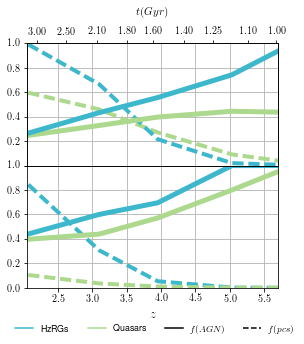

In [60]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(4.5,4.5))

plt.subplots_adjust(hspace=0)

z_lim = 5

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar[:z_lim]]) / n_clust[:z_lim], 
        c=cmap[1], lw=4, linestyle='dashed')

ax1.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio[:z_lim]]) / n_clust[:z_lim], 
          c=cmap[4], lw=4, linestyle='dashed')

# cons
ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_radio_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[4], lw=4, linestyle='dashed')

ax2.plot(zees[:z_lim], np.array([float(np.sum([x > 0 for x in y])) for y in n_quasar_cons[:z_lim]]) / n_clust[:z_lim], 
         c=cmap[1], lw=4, linestyle='dashed')


ax1.plot(zees[:z_lim], np.array(quasar_in_pcs[:z_lim])/np.array(all_quasar[:z_lim]), c=cmap[1], lw=5)
ax1.plot(zees[:z_lim], np.array(radio_in_pcs[:z_lim])/np.array(all_radio[:z_lim]), c=cmap[4], lw=5)

#cons
ax2.plot(zees[:z_lim], np.array(quasar_in_pcs_cons[:z_lim])/np.array(all_quasar_cons[:z_lim]), c=cmap[1], lw=5)
ax2.plot(zees[:z_lim], np.array(radio_in_pcs_cons[:z_lim])/np.array(all_radio_cons[:z_lim]), c=cmap[4], lw=5)


ax2.set_xlabel('$z$', size=13)

for ax in [ax1,ax2]:
    ax.set_ylim(0, 1)
    ax.grid()
    #ax.set_ylabel('$f$', rotation=0, size=20)
    
axt = ax1.twiny()
axt.set_xticks(ageticks)
axt.set_xticklabels(["$%.2f$"%age for age in ages.value]);

axt.set_xlabel('$t (Gyr)$', size=11, labelpad=12)

ax1.set_xticklabels([])
ax1.set_yticklabels(['','$0.2$','$0.4$','$0.6$','$0.8$','$1.0$'])

ax1.set_xlim(2.05, 5.7)
ax2.set_xlim(2.05, 5.7)
axt.set_xlim(2.05, 5.7)

line1 = plt.Line2D((0,1),(0,0), color=cmap[4], linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color=cmap[1], linestyle='solid')

line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')

ax2.legend(handles=[line1, line2, line3, line4], 
           labels=['HzRGs','Quasars',r'$f(AGN)$',r'$f(pcs)$'], 
           loc=(-0.06, -0.4), prop={'size':9}, frameon=False, ncol=4)


# plt.savefig('output/agn_stats.png', bbox_inches='tight', dpi=300)